# Quick Analysis of COVID-19 confirmed cases data

I've been quite frustrated with the data showing raw cases.  I'm much more interested in how many cases there are compared with the total population of a country or region.  The following adjusts the latest confirmed cases data to adjust for the total population of the country or region.  All numbers are percentages, and as you can tell, they are quite small at the moment.  But it's helpful for comparisons.

Data was sourced from: https://github.com/CSSEGISandData/COVID-19

In [1]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dateparser
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
pop_filename='./general_data/world-pop.csv'
pop = pd.read_csv(pop_filename)
pop['region'] = pop['region'].fillna('')
pop = pop.set_index(['country', 'region'])

In [3]:
filename='csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
df = pd.read_csv(filename, skiprows=0)
df = df.drop(columns=['Lat', 'Long'])

# cleanup column names
columns = {'Province/State': 'region', 'Country/Region': 'country'}
for c in df.columns:
    d = dateparser.parse(c)
    if d:
        columns[c] = d.strftime("%Y-%m-%d")
df = df.rename(columns=columns)
df['region'] = df['region'].fillna('')
df = df.set_index(['country', 'region'])

def by_country(df, names):
    df = df.loc[names]
    df = pd.merge(df, pop,  how='left', left_on=['country', 'region'], right_on=['country', 'region'])
    for d in df.columns:
        if d in ['country', 'population']:
            continue
        p = df['population']
        df[d] = df[d].divide(p)*100.0
    df = df.drop(columns=['population'])
    df = df.transpose()
    return df


# Canadian Provices - Percentage of population confirmed

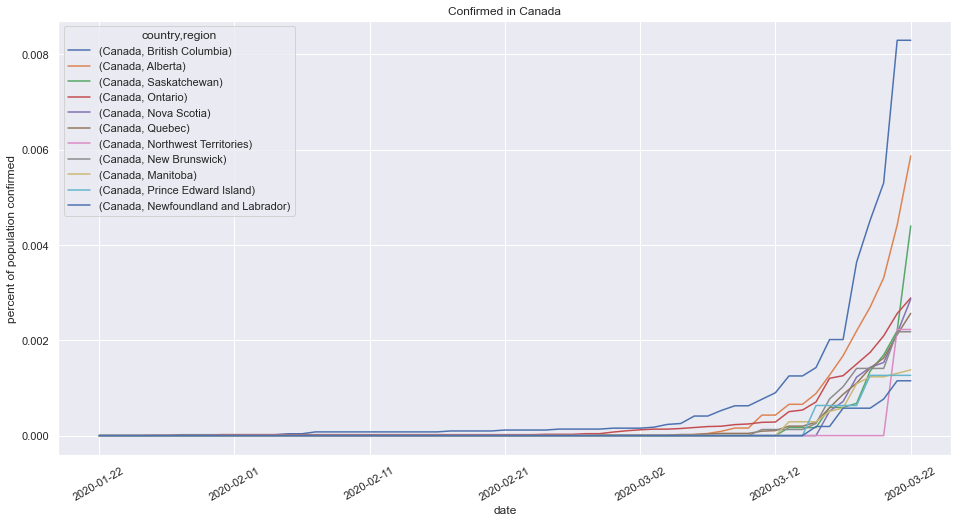

In [4]:
areas = list(filter(lambda x: x[0] =='Canada', df.index))
canada = by_country(df, areas)
last_date = max(canada.index)
sorted_columns = canada.transpose().sort_values(by=[last_date], ascending=False).transpose().columns
columns = list(filter(lambda x: len(x[1].split(",")) == 1 and x[1].find("Princess") == -1, sorted_columns))
canada = canada[columns]

ax = canada.plot(rot=30, figsize=(16,8), title='Confirmed in Canada')
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
pass

In [5]:
canada.tail()

country              Canada                                               \
region     British Columbia   Alberta Saskatchewan   Ontario Nova Scotia   
2020-03-18         0.003639  0.002198     0.000677  0.001502    0.001228   
2020-03-19         0.004520  0.002696     0.001354  0.001747    0.001432   
2020-03-20         0.005302  0.003308     0.001693  0.002094    0.001535   
2020-03-21         0.008296  0.004419     0.002200  0.002563    0.002148   
2020-03-22         0.008296  0.005869     0.004401  0.002889    0.002865   

country                                                             \
region        Quebec Northwest Territories New Brunswick  Manitoba   
2020-03-18  0.001101              0.000000       0.00141  0.001089   
2020-03-19  0.001417              0.000000       0.00141  0.001234   
2020-03-20  0.001628              0.000000       0.00141  0.001234   
2020-03-21  0.002120              0.002227       0.00218  0.001307   
2020-03-22  0.002565              0.002227       0.00218  0.001379   

country                                                    
region     Prince Edward Island Newfoundland and Labrador  
2020-03-18             0.000632                  0.000575  
2020-03-19             0.001265                  0.000575  
2020-03-20             0.001265                  0.000767  
2020-03-21             0.001265                  0.001151  
2020-03-22             0.001265                  0.001151

# US States - Percentage of population confirmed

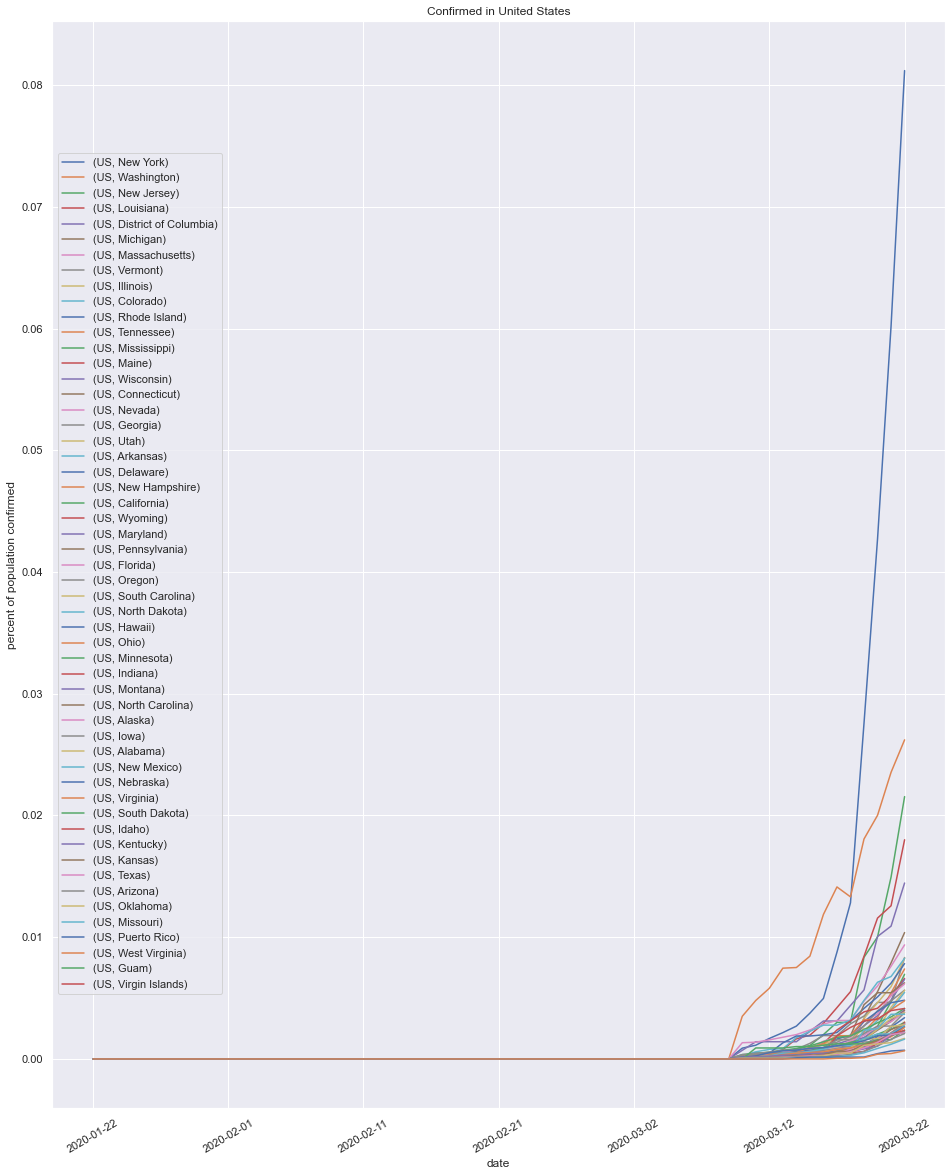

In [6]:
areas = list(filter(lambda x: x[0] =='US', df.index))
usa = by_country(df, areas)
last_date = max(usa.index)
sorted_columns = usa.transpose().sort_values(by=[last_date], ascending=False).transpose().columns
columns = list(filter(lambda x: len(x[1].split(",")) == 1 and x[1].find("Princess") == -1, sorted_columns))
usa = usa[columns]
ax = usa.plot(rot=30, figsize=(16,20), title='Confirmed in United States')
ax.legend(bbox_to_anchor=(0, 0.1))
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
pass

# Percentage of Population Confirmed - Top 12 US States

In [7]:
usa[columns[:12]].tail()

country           US                                                       \
region      New York Washington New Jersey Louisiana District of Columbia   
2020-03-18  0.012825   0.013316   0.003006  0.005528             0.004392   
2020-03-19  0.027578   0.018070   0.008354  0.008432             0.005668   
2020-03-20  0.042717   0.020013   0.010020  0.011573             0.010060   
2020-03-21  0.060195   0.023546   0.014940  0.012584             0.010910   
2020-03-22  0.081183   0.026212   0.021549  0.018005             0.014453   

country                                                                        \
region      Michigan Massachusetts   Vermont  Illinois  Colorado Rhode Island   
2020-03-18  0.000831      0.003163  0.002885  0.001278  0.003195     0.003115   
2020-03-19  0.003344      0.004759  0.003526  0.003330  0.004810     0.004153   
2020-03-20  0.005527      0.005992  0.004648  0.004617  0.006303     0.005097   
2020-03-21  0.007890      0.007617  0.004648  0.005942  0.006772     0.006230   
2020-03-22  0.010384      0.009373  0.008333  0.008278  0.008266     0.007835   

country               
region     Tennessee  
2020-03-18  0.001157  
2020-03-19  0.002255  
2020-03-20  0.003412  
2020-03-21  0.005433  
2020-03-22  0.007395

# Comparison of areas of interest
## Percentage of population confirmed

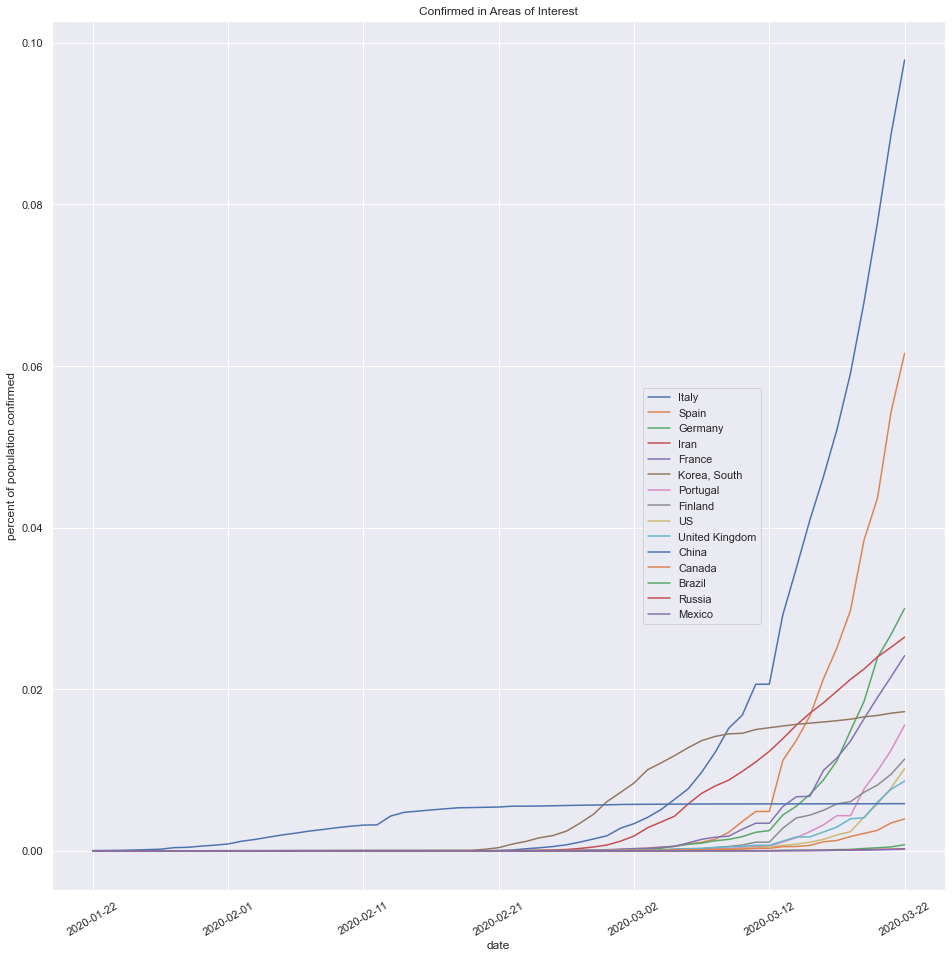

In [8]:
areas_of_interest = ['Canada', 'US', 'Iran', 'China', 'Korea, South', 'Italy', 'Spain',
                    'Germany', 'France', 'United Kingdom', 'Russia', 'Finland', 'Portugal',
                    'Brazil', 'Mexico']

def f(x):
    if x[0] not in areas_of_interest:
        return False
    
    return True
    
areas = list(filter(f, df.index))

def f_pop(x):
    if x[0] not in areas_of_interest:
        return False
    if x[1] != "":
        return False
    return True

filtered_pop = pop.loc[list(filter(f_pop, pop.index))]

grouped = df.loc[areas].groupby(by=['country']).sum()
grouped = pd.merge(grouped, filtered_pop,  how='left', left_on=['country'], right_on=['country'])

for d in grouped.columns:
    if d in ['country', 'population']:
        continue
    p = grouped['population']
    grouped[d] = grouped[d].divide(p)*100.0
grouped = grouped.drop(columns=['population'])
grouped = grouped.transpose()

last_date = max(grouped.index)
sorted_columns = grouped.transpose().sort_values(by=[last_date], ascending=False).transpose().columns
columns = list(filter(lambda x: len(x[1].split(",")) == 1 and x[1].find("Princess") == -1, sorted_columns))
grouped = grouped[columns]
ax = grouped.plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(bbox_to_anchor=(0.8, 0.3))
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
pass

## Comparison of areas of interest - Percent of Population confirmed

In [9]:
grouped.tail(6)

country,Italy,Spain,Germany,Iran,France,"Korea, South",Portugal,Finland,US,United Kingdom,China,Canada,Brazil,Russia,Mexico
2020-03-17,0.052135,0.025144,0.011163,0.019766,0.011493,0.016113,0.004357,0.005817,0.001963,0.002948,0.005820,0.001290,0.000153,0.000079,0.000065
2020-03-18,0.059097,0.029771,0.014865,0.021224,0.013592,0.016293,0.004357,0.006089,0.002379,0.003974,0.005823,0.001773,0.000178,0.000102,0.000074
2020-03-19,0.067904,0.038445,0.018474,0.022502,0.016342,0.016588,0.007635,0.007249,0.004180,0.004085,0.005827,0.002159,0.000296,0.000138,0.000094
2020-03-20,0.077809,0.043682,0.023934,0.024015,0.018998,0.016756,0.009920,0.008155,0.005838,0.006037,0.005834,0.002545,0.000379,0.000175,0.000130
2020-03-21,0.088659,0.054306,0.026786,0.025196,0.021543,0.017041,0.012449,0.009478,0.007791,0.007621,0.005838,0.003449,0.000487,0.000212,0.000161
2020-03-22,0.097860,0.061570,0.029994,0.026452,0.024148,0.017230,0.015562,0.011345,0.010170,0.008635,0.005844,0.003953,0.000760,0.000254,0.000199


# Select US States and Canadian Provinces
## Percentage of population confirmed

In [10]:
interest = [('US', 'Texas'), ('US', 'Utah'), ('US', 'California'), ('Canada', 'British Columbia'), ('Canada', 'Ontario')]
data = df.loc[interest]
data = pd.merge(data, pop,  how='left', left_on=['country', 'region'], right_on=['country', 'region'])
for d in data.columns:
    if d in ['country', 'population']:
        continue
    p = data['population']
    data[d] = data[d].divide(p)*100.0
data = data.drop(columns=['population'])

tdata = data.transpose()
last_date = max(tdata.index)
columns = data.sort_values(by=[last_date], ascending=False).transpose().columns
tdata = tdata[columns]
tdata.tail()

country              Canada        US               Canada        US
region     British Columbia      Utah California   Ontario     Texas
2020-03-18         0.003639  0.001591   0.001901  0.001502  0.000597
2020-03-19         0.004520  0.002495   0.002409  0.001747  0.000897
2020-03-20         0.005302  0.002433   0.002979  0.002094  0.001359
2020-03-21         0.008296  0.004242   0.003452  0.002563  0.002004
2020-03-22         0.008296  0.005646   0.004156  0.002889  0.002162

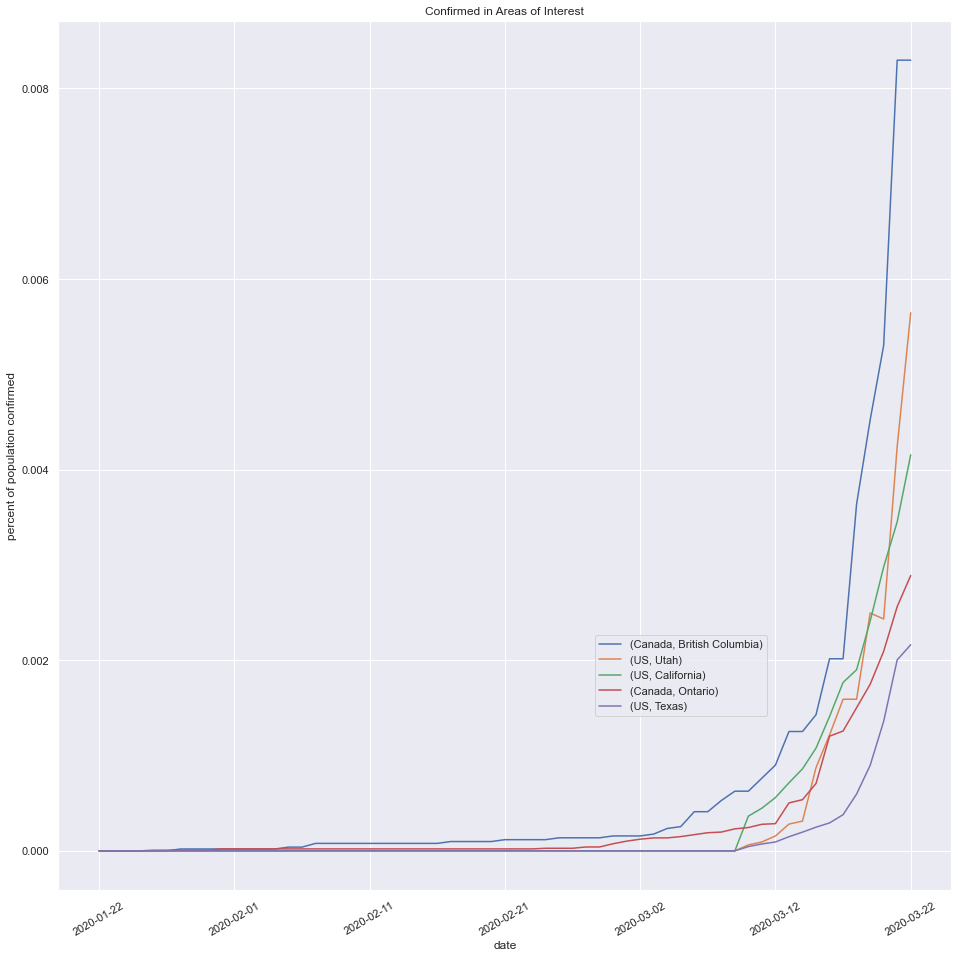

In [11]:
ax = tdata.plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(bbox_to_anchor=(0.8, 0.3))
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
pass
